In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
!pip install mediapipe
import mediapipe as mp
import os
import json

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.0 MB 1.4 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.11.23 which is incompatible.


# Get JSON input files

In [ ]:
#input_json_path = '/content/drive/MyDrive/test_json/'
input_json_path = '/content/drive/MyDrive/145_sample_test_json/'
#input_json_path = '/content/drive/Shareddrives/URSI 2022/Eye Tracking ML/json_inputs/'

all_input_json_files = os.listdir(input_json_path)

input_json_data = {}
for filename in all_input_json_files:
  with open(input_json_path + filename, 'r') as file:
    s_data = json.load(file)
    input_json_data = {**input_json_data, **s_data}

input_json_path should be changed depending on which json location should be used. For using the general dataset in the google drive, option 3 should be used 

# Set Training Labels and Training Data

In [ ]:
calibration_points = [[10, 50], [10, 10], [90, 10], [50, 90],
                   [30, 70], [50, 50], [50, 10], [90, 90],
                   [70, 70], [70, 30], [10, 90], [90, 50],
                   [30, 30]]

In [ ]:
train_y = []

for subject in input_json_data:
    for y in input_json_data[subject]['y']:
        train_y.append(y)
        for element in calibration_points:
            train_y.append(element)

print(len(train_y))
#print(train_y)

176050


In [ ]:
train_x = []

for subject in input_json_data:
    for sample in input_json_data[subject]['x']:
        calibration_arr = []
        for point in sample:
            total_arr = []
            head_pose = np.array(point[0])
            iris_points = np.array(point[1])
            head_pose = head_pose.flatten()
            iris_points = iris_points.flatten()
            for element in head_pose:
                total_arr.append(element)
            for element in iris_points:
                total_arr.append(element)
            calibration_arr.append(total_arr)
        #train_x.append(calibration_arr[0])
        for element in calibration_arr:
            train_x.append(element)

In [ ]:
print(np.shape(train_x))
print(np.shape(train_y))

(176050, 22)
(176050, 2)


## Normalize and Shuffle Training Data

In [ ]:
train_x = np.array(train_x)
mean = train_x.mean(axis=0)
train_x -= mean
std = train_x.std(axis=0)
train_x /= std
train_y = np.array(train_y)

In [ ]:
from sklearn.utils import shuffle

train_x, train_y = shuffle(train_x, train_y)

In [ ]:
print(np.shape(train_x))
print(np.shape(train_y))

(176050, 22)
(176050, 2)


# Set Validation Labels and Validation Data

### Option 1. Reserve a portion of Training data for Validation Data

In [ ]:
val_x = train_x[0:(int((len(train_x)) / 2))]
val_y = train_y[0:(int((len(train_y)) / 2))]
train_x = train_x[(int((len(train_x)) / 2)):int(len(train_x))]
#train_x = train_x[(int((len(train_x)) / 2)):(int((len(train_x)) / 2 + 2))]

train_y = train_y[(int((len(train_y)) / 2)):int(len(train_y))]
#train_y = train_y[(int((len(train_y)) / 2)):(int((len(train_y)) / 2 + 2))]

In [ ]:
print(np.shape(train_x))
print(np.shape(train_y))

(88025, 22)
(88025, 2)


### Option 2. Test Training Data against separately reserved Validation Data not part of the original dataset

In [ ]:
validation_input_json_path = '/content/drive/MyDrive/test_validation_json/'
all_input_json_files = os.listdir(validation_input_json_path)

validation_input_json_data = {}
for filename in all_input_json_files:
  with open(validation_input_json_path + filename, 'r') as file:
    s_data = json.load(file)
    validation_input_json_data = {**validation_input_json_data, **s_data}

In [ ]:
val_x = []
val_y = []

for subject in validation_input_json_data:
    for y in validation_input_json_data[subject]['y']:
        val_y.append(y)

for subject in validation_input_json_data:
    for sample in validation_input_json_data[subject]['x']:
        calibration_arr = []
        for point in sample:
            total_arr = []
            head_pose = np.array(point[0])
            iris_points = np.array(point[1])
            head_pose = head_pose.flatten()
            iris_points = iris_points.flatten()
            for element in head_pose:
                total_arr.append(element)
            for element in iris_points:
                total_arr.append(element)
            calibration_arr.append(total_arr)
        val_x.append(calibration_arr[0])

In [ ]:
val_x = np.array(val_x)
mean = val_x.mean(axis=0)
val_x -= mean
std = val_x.std(axis=0)
val_x /= std
val_y = np.array(val_y)

In [ ]:
print(np.shape(val_x))
print(np.shape(val_y))

(449, 22)
(449, 2)


In [ ]:
val_x[0]

array([ 1.14481967, -0.92332458, -1.65542417,  1.22110669,  1.22160099,
       -1.034942  ,  0.57210006, -1.4200834 ,  0.49469667, -1.1214948 ,
        0.47459499, -1.52315254,  0.54280131, -0.98261294, -0.12116809,
       -1.20683347, -0.0439962 , -0.67836648, -0.0277248 , -1.53982132,
       -0.1133226 , -0.92976117])

# Model with Real Data

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([layers.Dense(128, activation="relu"), layers.Dense(64, activation="relu"), layers.Dense(16, activation="relu"), layers.Dense(2, activation="relu")])
model.compile(optimizer=keras.optimizers.RMSprop(1e-2), loss="MeanSquaredError", metrics=["mae"])

history = model.fit(train_x, train_y, epochs=70, batch_size=40000, validation_data=(val_x, val_y))

Epoch 1/70
3/3 [==============================] - 3s 179ms/step - loss: 2819.9070 - mse: 2819.9070 - val_loss: 1283.8638 - val_mse: 1283.8638
Epoch 2/70
3/3 [==============================] - 0s 82ms/step - loss: 1562.2917 - mse: 1562.2917 - val_loss: 1078.2448 - val_mse: 1078.2448
Epoch 3/70
3/3 [==============================] - 0s 78ms/step - loss: 1158.6385 - mse: 1158.6385 - val_loss: 922.8353 - val_mse: 922.8353
Epoch 4/70
3/3 [==============================] - 0s 78ms/step - loss: 1064.0660 - mse: 1064.0660 - val_loss: 967.3485 - val_mse: 967.3485
Epoch 5/70
3/3 [==============================] - 0s 81ms/step - loss: 1049.3121 - mse: 1049.3119 - val_loss: 914.3710 - val_mse: 914.3710
Epoch 6/70
3/3 [==============================] - 0s 89ms/step - loss: 1000.2245 - mse: 1000.2245 - val_loss: 903.4274 - val_mse: 903.4274
Epoch 7/70
3/3 [==============================] - 0s 76ms/step - loss: 952.7498 - mse: 952.7498 - val_loss: 857.0207 - val_mse: 857.0207
Epoch 8/70
3/3 [========

## Validation Metrics

In [ ]:
model.evaluate(val_x, val_y)

15/15 [==============================] - 0s 2ms/step - loss: 630.6418 - mse: 630.6418


[630.6417846679688, 630.6417846679688]

15/15 [==============================] - 0s 2ms/step


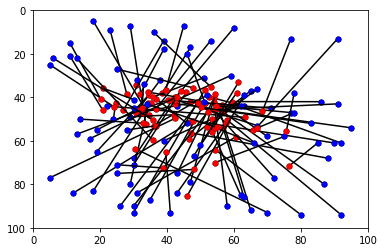

In [ ]:
plt.xlim(0, 100)
plt.ylim(100, 0)
x2 = []
y2 = []
sample_num = 0
while sample_num <= 90:
    x = [val_y[sample_num][0]]
    x2 = [(val_y[sample_num][0])]
    x.append(model.predict(val_x)[sample_num][0])
    x3 = [model.predict(val_x)[sample_num][0]]
    y = [val_y[sample_num][1]]
    y2 = [(val_y[sample_num][1])]
    y.append(model.predict(val_x)[sample_num][1])
    y3 = [model.predict(val_x)[sample_num][1]]
    plt.plot(x, y, color="black", marker="o", markersize=5)
    plt.plot(x3, y3, color="red", marker="o", markersize=5)
    plt.plot(x2, y2, color="blue", marker="o", markersize=5)
    sample_num += 1



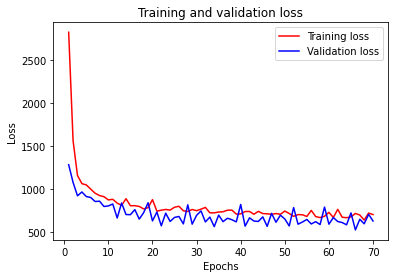

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.clf()
acc = history_dict["mae"]
val_acc = history_dict["val_mae"]
plt.plot(epochs, acc, "r", label="Training mae")
plt.plot(epochs, val_acc, "b", label="Validation mae")
plt.title("Training and validation mae")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

KeyError: ignored

<Figure size 432x288 with 0 Axes>

# Issues/Concerns

**After normalizing val_x:** Validation mae often gets to values less than training mae itself

**For trials using the shuffled val_x and val_y:** (Not Overfitting?) Graph indicates that validation data may be leaking into training data somewhere. Since the calibration points are being included in the training dataset for this model, another possibility is that the model is learning to find which calibration point a point is closest to and then give that calibration point as the prediction. This would give it a high mae since many calibration points have similar encoded face values and iris coordinates meaning that even with shuffling, the model would have seen many inputs that were similar to the validation data beforehand